In [2]:
# ===== LOCAL BENCHMARK =====
import os, time, hashlib
import pandas as pd

sizes_mb = [1, 10, 100, 500, 1024, 2048, 4096]  # same as Colab
os.makedirs("local_files", exist_ok=True)

for size in sizes_mb:
    fname = f"local_files/file_{size}MB.bin"
    if not os.path.exists(fname):
        print(f"Creating {fname} ...")
        with open(fname, "wb") as f:
            f.write(os.urandom(size * 1024 * 1024))

CHUNK = 1024*1024
LIST_CHUNK = 1024**3

def naive_hash(filepath):
    h = hashlib.sha256()
    with open(filepath, "rb") as f:
        while block := f.read(CHUNK):
            h.update(block)
    return h.digest()

def list_based_hash(filepath):
    chunk_hashes, h, size = [], hashlib.sha256(), 0
    with open(filepath, "rb") as f:
        while block := f.read(CHUNK):
            h.update(block); size += len(block)
            if size >= LIST_CHUNK:
                chunk_hashes.append(h.digest()); h = hashlib.sha256(); size = 0
        if size > 0: chunk_hashes.append(h.digest())
    return hashlib.sha256(b"".join(chunk_hashes)).digest()

results_local = {"size_gb": [], "naive_time": [], "list_time": []}
for size in sizes_mb:
    filepath = f"local_files/file_{size}MB.bin"
    size_gb = size/1024
    
    t0 = time.time(); naive_hash(filepath); t1 = time.time()
    naive_t = t1-t0
    
    t0 = time.time(); list_based_hash(filepath); t1 = time.time()
    list_t = t1-t0
    
    results_local["size_gb"].append(size_gb)
    results_local["naive_time"].append(naive_t)
    results_local["list_time"].append(list_t)
    print(f"Local {size}MB: Naive {naive_t:.2f}s | List {list_t:.2f}s")

df_local = pd.DataFrame(results_local)
df_local.to_csv("results_local.csv", index=False)
df_local


Creating local_files/file_1MB.bin ...
Creating local_files/file_10MB.bin ...
Creating local_files/file_100MB.bin ...
Creating local_files/file_500MB.bin ...
Creating local_files/file_1024MB.bin ...
Creating local_files/file_2048MB.bin ...
Creating local_files/file_4096MB.bin ...
Local 1MB: Naive 0.01s | List 0.00s
Local 10MB: Naive 0.03s | List 0.03s
Local 100MB: Naive 0.29s | List 0.31s
Local 500MB: Naive 1.37s | List 1.43s
Local 1024MB: Naive 2.81s | List 2.98s
Local 2048MB: Naive 5.55s | List 5.79s
Local 4096MB: Naive 11.11s | List 11.66s


,size_gb,naive_time,list_time
0,0.000977,0.012002,0.001997
1,0.009766,0.033000,0.026522
2,0.097656,0.289671,0.310049
3,0.488281,1.369028,1.426090
4,1.000000,2.811886,2.983896
5,2.000000,5.548780,5.785324
6,4.000000,11.107122,11.655452


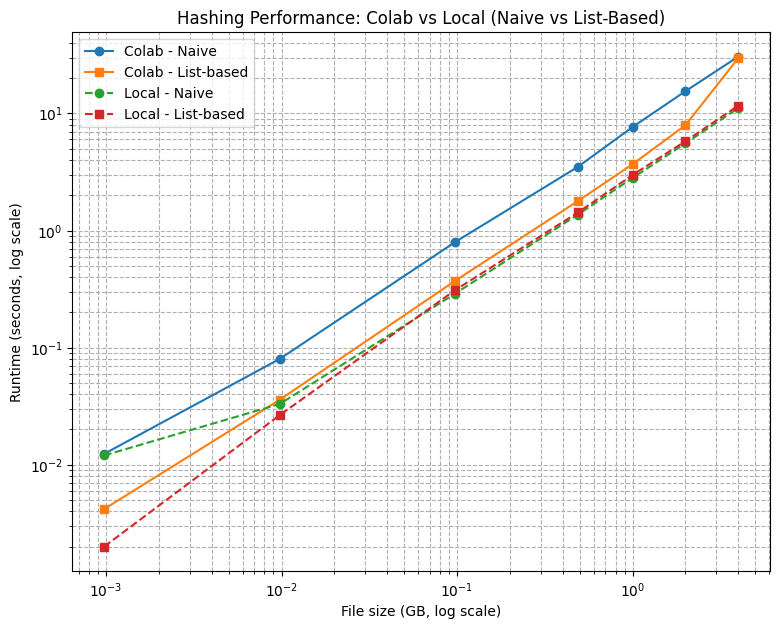

In [6]:
# ===== COMPARISON: COLAB vs LOCAL =====
import matplotlib.pyplot as plt
import pandas as pd

df_colab = pd.read_csv("results_colab.csv")
df_local = pd.read_csv("results_local.csv")

plt.figure(figsize=(9,7))

# Plot Colab results
plt.loglog(df_colab["size_gb"], df_colab["naive_time"], "o-", label="Colab - Naive")
plt.loglog(df_colab["size_gb"], df_colab["list_time"], "s-", label="Colab - List-based")

# Plot Local results
plt.loglog(df_local["size_gb"], df_local["naive_time"], "o--", label="Local - Naive")
plt.loglog(df_local["size_gb"], df_local["list_time"], "s--", label="Local - List-based")

plt.xlabel("File size (GB, log scale)")
plt.ylabel("Runtime (seconds, log scale)")
plt.title("Hashing Performance: Colab vs Local (Naive vs List-Based)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
